# Курс Специализация Data Science Дипломный проект. 
## Бриф учебного кейса «Лаборатории исследований гражданского общества». Государственные деньги у НКО»

### Предобработка данных

In [2]:
import os, json, io, re
import pandas as pd
import numpy as np
import glob
pd.set_option('display.max_columns', None)
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from dadata import Dadata
import category_encoders as ce
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import accuracy_score, confusion_matrix

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
path_to_json = 'C:/Users/Anna/Documents/IDE/DIPLOM/*' 

json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

In [4]:
def merge_JsonFiles(filename):
    result = list()
    for f1 in filename:
        with io.open(f1,'r',encoding='utf-8') as infile:
            list_json_line = [json.loads(line) for line in infile]
            result.extend(list_json_line)
    return result

result = merge_JsonFiles(file_list)

In [5]:
initial_data = pd.json_normalize(result, max_level=1)

In [6]:
initial_data.columns = [re.sub("\.", "_", c) for c in initial_data.columns]

initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 59 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   minjustRegNum              462302 non-null  object 
 1   regionName                 747009 non-null  object 
 2   logo                       0 non-null       object 
 3   fullName                   747034 non-null  object 
 4   dateReg                    0 non-null       float64
 5   minjustForm                462302 non-null  object 
 6   charter                    0 non-null       object 
 7   minjustStatus              462302 non-null  object 
 8   ogrn                       747034 non-null  object 
 9   egrulStatus                747034 non-null  object 
 10  regionCode                 747034 non-null  object 
 11  incomeTotal                747034 non-null  float64
 12  email                      8158 non-null    object 
 13  administrators             74

In [7]:
df = initial_data.copy()

Text(0.5, 1.0, 'Соотношение организаций, получавших и не получавших поддержку')

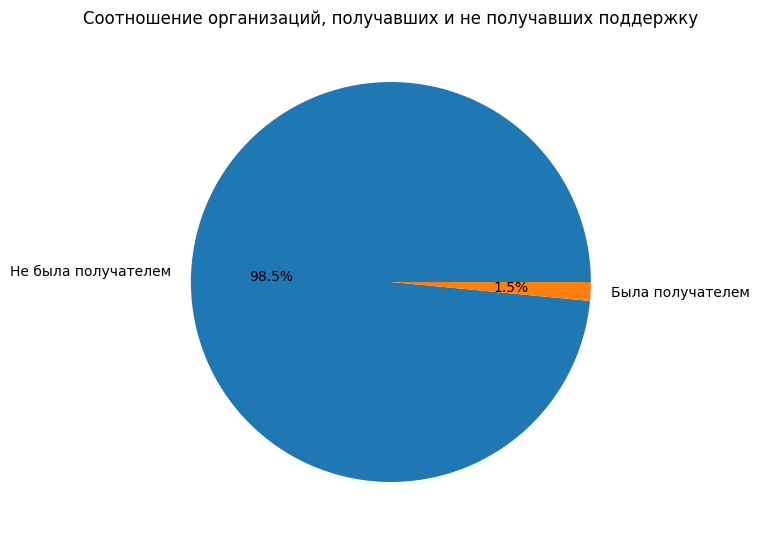

In [8]:
df_1 = df.groupby(by='hasRegionalSupport')['hasRegionalSupport'].count()

fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    df_1,
    labels= ["Не была получателем","Была получателем"],
    autopct='%.1f%%',
    explode= [0,0]  
)
axes.set_title('Соотношение организаций, получавших и не получавших поддержку')

Значения целевого признака не сбалансированы. 

Определим наличие пропусков

In [9]:
cols_null_percent = df.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

logo                     100.000000
dateReg                  100.000000
charter                  100.000000
dateLiquid               100.000000
socialMedia_instagram     99.999866
socialMedia_ok            99.999732
socialMedia_youtube       99.999732
socialMedia_twitter       99.999732
socialMedia_vk            99.999331
socialMedia_facebook      99.999331
website_punycode          99.292402
website                   99.292402
email                     98.907948
statusDetail_code         97.690467
statusDetail_name         97.690467
oktmo_name                63.092175
dateReg_$date             56.974381
okato_name                54.724952
okogu_name                53.492612
okpo                      53.491140
okfs_code                 53.491140
oktmo_code                53.491140
okfs_name                 53.491140
okato_code                53.491140
okogu_code                53.491140
dateLiquid_$date          46.460134
minjustRegNum             38.114999
minjustStatus             38

In [10]:
display(df[df['statusDetail_code'].notnull()][['statusDetail_code','statusDetail_name']].head())
#Признаки statusDetail_code и statusDetail_name дублируют друг друга, имеют много пропусков, 
# но пока оставим statusDetail_code, заменив пропуски строкой "000"
df.statusDetail_code = df.statusDetail_code.apply(lambda x: x if x is not None else "000")

display(df[df['dateReg_$date'].notnull()][['dateReg_$date','originDate_$date']].head())
#В признаке originDate_$date дублируется признак dateReg_$date для организаций, зарегистрированных до 2002 года и
# признак dateOgrn_$date для организаций, зарегистрированных с 2002. Признак dateReg_$date можно удалить

,statusDetail_code,statusDetail_name
44,112,Юридическим лицом принято решение об изменении...
135,112,Юридическим лицом принято решение об изменении...
145,112,Юридическим лицом принято решение об изменении...
171,101,Находится в стадии ликвидации
194,101,Находится в стадии ликвидации


,dateReg_$date,originDate_$date
123,1991-04-12T00:00:00.000Z,1991-04-12T00:00:00.000Z
202,2002-01-29T00:00:00.000Z,2002-01-29T00:00:00.000Z
287,1996-03-21T00:00:00.000Z,1996-03-21T00:00:00.000Z
290,1989-07-20T00:00:00.000Z,1989-07-20T00:00:00.000Z
397,1993-06-02T00:00:00.000Z,1993-06-02T00:00:00.000Z


In [11]:
# Удалим признаки с долей пропусков свыше 64%
df = df.drop(cols_with_null[cols_null_percent>64].index,axis=1)

Пробуем заполнить пропуски значениями, взятыми из внешнего источника

In [12]:
russian_companies = pd.read_csv('data/data-20220314-structure-20220314.csv',sep=';').\
    rename(columns={'ОГРН / ОГРНИП':'ogrn'})
#russian_companies.head(3)

In [13]:
list_code_names = ["okato_code","oktmo_code","okogu_code","okfs_code","okpo","ogrn"]
for i in list_code_names:
    df[i]=df[i].astype(float)

df=df.merge(
    russian_companies,
    on='ogrn',
    how='left'
    )

df['okato_code']=df['okato_code'].combine_first(df['ОКАТО заявленный при регистрации'])
df['oktmo_code']=df['oktmo_code'].combine_first(df['ОКТМО заявленный при регистрации'])
df['okogu_code']=df['okogu_code'].combine_first(df['ОКОГУ'])
df['okfs_code']=df['okfs_code'].combine_first(df['ОКФС'])
df['okpo']=df['okpo'].combine_first(df['ОКПО'])

In [14]:
# определим наличие пропусков
cols_null_percent = df.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

oktmo_name                          63.092006
dateReg_$date                       56.974497
ИНН                                 54.768311
ОКОПФ                               54.764964
ОКФС                                54.764964
ОКОГУ                               54.764964
ОКТМО заявленный при регистрации    54.764964
ОКАТО заявленный при регистрации    54.764964
ОКПО                                54.764964
Полное наименование объекта         54.764964
okato_name                          54.724806
okogu_name                          53.492469
okfs_name                           53.490996
oktmo_code                          50.523536
okato_code                          50.523536
okpo                                50.523536
okfs_code                           50.523536
okogu_code                          50.523536
dateLiquid_$date                    46.460278
minjustStatus                       38.114897
minjustForm                         38.114897
minjustRegNum                     

Не совсем удачная попытка (+3%), рассмотрим поэтапно признаки

In [15]:
# Удалим признаки с долей пропусков свыше 51%
df = df.drop(cols_with_null[cols_null_percent>51].index,axis=1)

Будем удалять признаки. minjustStatus - номинальный, minjustForm - дублирует информацию из ОПФ.

minjustStatus закодируем: пропуски - 0, Зарегистрирована - 2, Исключена - 1

Пропуски признака opf_name заполним значениями из признака minjustForm

In [16]:
df['minjustStatus'] = df['minjustStatus'].apply(lambda x: '2' if x=='Зарегистрирована' else '1' if x=='Исключена' else '0')
df['opf_name']=df['opf_name'].combine_first(df['minjustForm'])

df = df.drop(['minjustRegNum','minjustForm'],axis=1)

### Рассмотрим признаки 'dateLiquid_$date' и egrulStatus. 

In [17]:
df = df.rename(columns={'originDate_$date':'originDate', 'dateOgrn_$date':'dateOgrn','dateLiquid_$date':'dateLiquid'})

In [18]:
display(df[df['dateLiquid'].isnull()]['egrulStatus'].value_counts())
display(df[df['dateLiquid'].notnull()]['egrulStatus'].value_counts())

egrulStatus
Действует        340902
Ликвидирована      6173
Name: count, dtype: int64

egrulStatus
Ликвидирована    399961
Name: count, dtype: int64

видим, что все компании с обозначенной датой ликвидации имеют статус "ликвидирована", но есть компании со статусом "ликвидирована", без обозначения даты ликвидации. Для кодировки статуса компании возьмем за основу признак egrulStatus. 

Создадим признак age: для ликвидированных компаний - это количество лет существования, для действующих - лет от даты создания до настоящего времени, для ликвидированных компаний без обозначенной даты ликвидации - среднее количества лет ликвидированных компаний

In [19]:
#приведем признаки дат в формат datetime
df['dateLiquid']=pd.to_datetime(df['dateLiquid'])
df['originDate']=pd.to_datetime(df['originDate'])
df['dateOgrn']=pd.to_datetime(df['dateOgrn'])

#присваиваем age ликвидированным компаниям
df['age']=(df['dateLiquid'].dt.year - df['originDate'].dt.year) 

#присваиваем age ликвидированным компаниям без даты ликвидации
liq_age_median = df['age'].head(25).median().round() #медианный age по ликвидированным компаниям
df['age'] = df[df['egrulStatus']=="Ликвидирована"]['age'].fillna(liq_age_median) 

#присваиваем age действующим компаниям
df['age'] = df['age'].fillna(date.today().year - df['originDate'].dt.year) #присваиваем age действующим компаниям
df['age'] = df['age'].astype(int)

df = df.drop(['dateLiquid'],axis=1)#удаляем признак dateLiquid

Посмотрим есть ли зависимость вероятности получения поддержки от возраста организации:

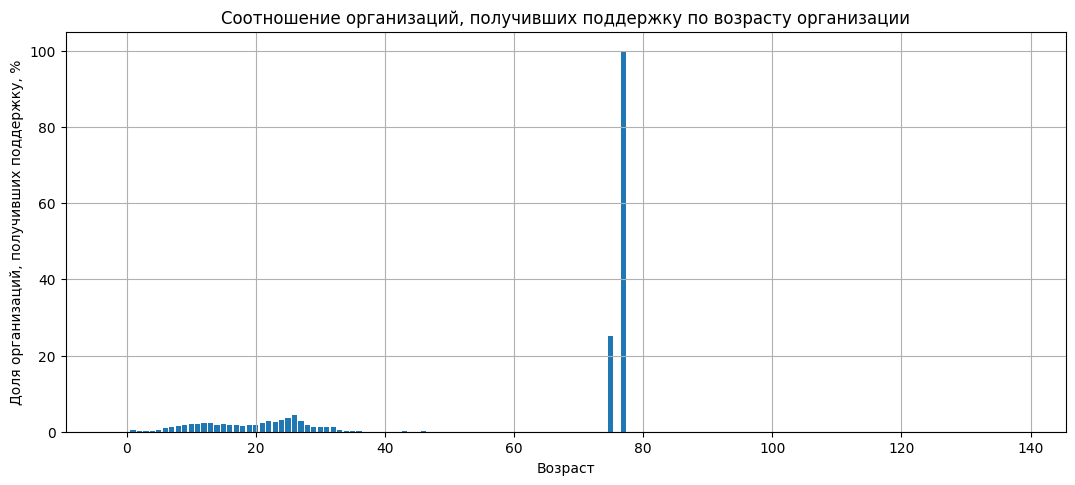

In [20]:
age_hasSupport = df.groupby(by=['age'])['hasRegionalSupport'].mean()*100

fig = plt.figure(figsize=(10,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(
    x = age_hasSupport.index,
    height = age_hasSupport
)
axes.set_title('Соотношение организаций, получивших поддержку по возрасту организации')
axes.set_xlabel("Возраст")
axes.set_ylabel('Доля организаций, получивших поддержку, %')
axes.grid()

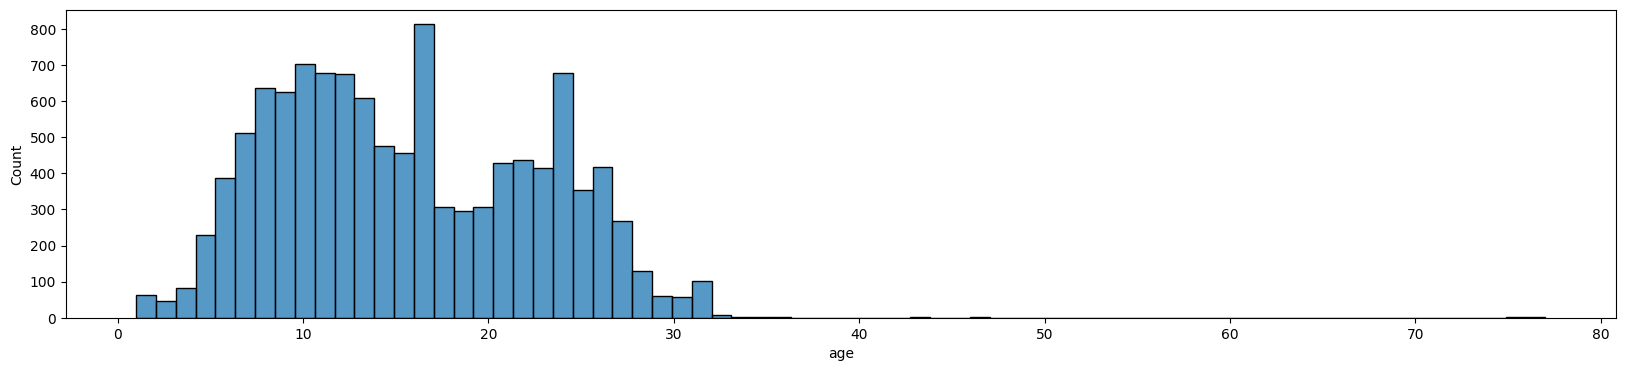

In [21]:
fig = plt.figure(figsize=(20,4))
histplot = sns.histplot(data=df[df['hasRegionalSupport']==True].sort_values('age'), x='age')

Видим многочисленные выбросы в признаке age. Рассмотрим признак ближе:

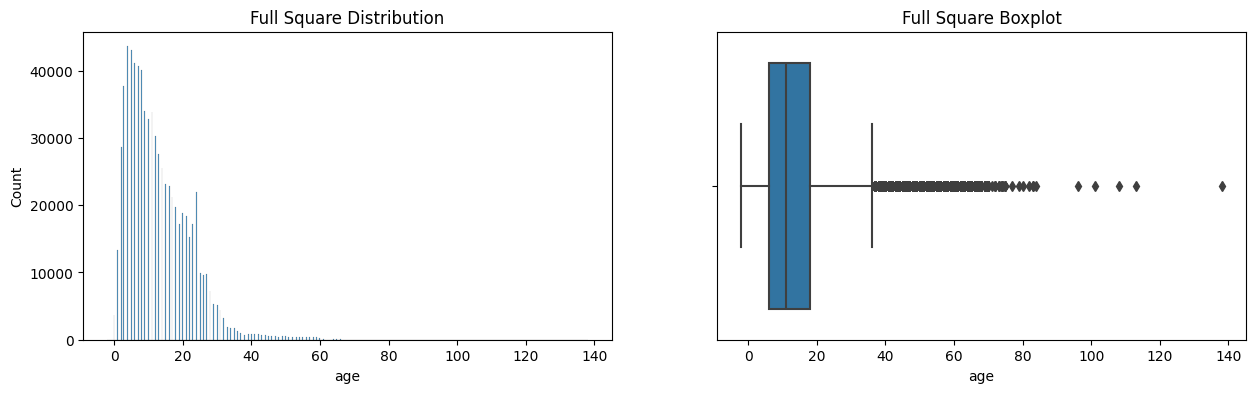

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='age', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=df, x='age', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

Имеем в наличии типичные графики распределений с выбросами в данных. Распределение не нормальное. Избавимся от выбросов методом сигм с логарифмированием признака age

In [23]:
# функция outliers_iqr_mod_log() принимает на вход DataFrame и признак, по которому 
# ищутся выбросы, а затем возвращает потенциальные выбросы, 
# найденные с помощью метода Тьюки, и очищенный от них датасет.
def outliers_z_score_mod(data, feature, log_scale=False, left=2.5, right=2.5):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(df, 'age')
#cleaned['age'].describe()

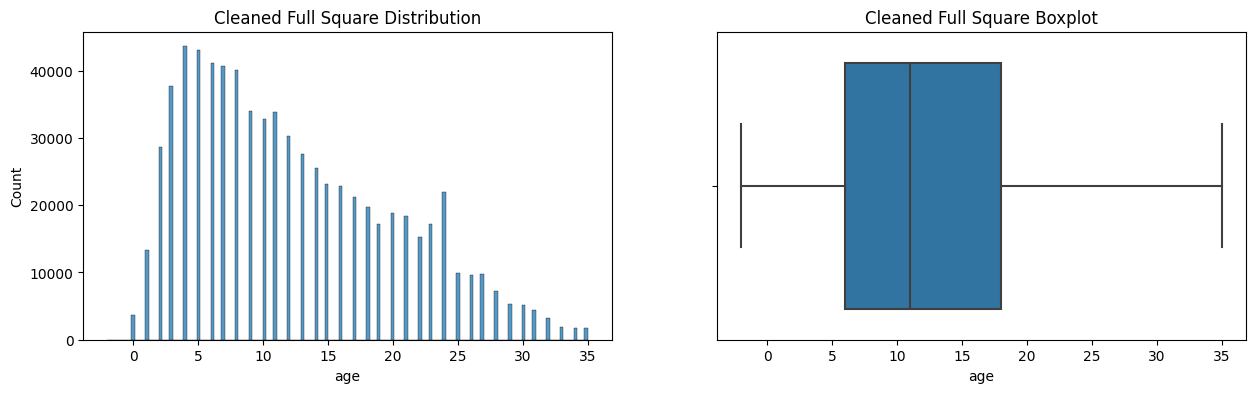

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='age', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='age', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [25]:
display(f'доля удаленных выбросов {round(outliers.shape[0]/df.shape[0]*100, 2)} %')

'доля удаленных выбросов 2.02 %'

Поссмотрим на график 'Соотношение организаций, получивших поддержку по возрасту организации'

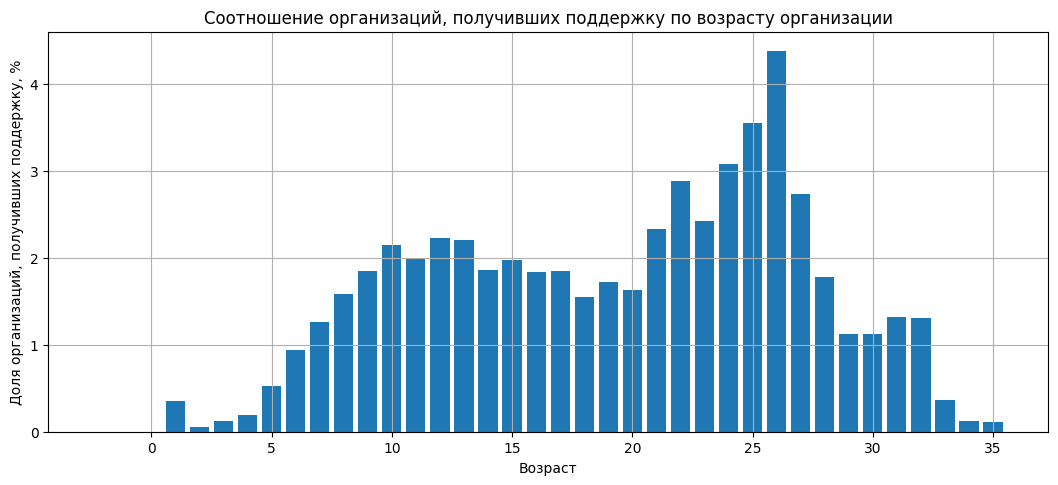

In [26]:
age_hasSupport = cleaned.groupby(by=['age'])['hasRegionalSupport'].mean()*100

fig = plt.figure(figsize=(10,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(
    x = age_hasSupport.index,
    height = age_hasSupport
)
axes.set_title('Соотношение организаций, получивших поддержку по возрасту организации')
axes.set_xlabel("Возраст")
axes.set_ylabel('Доля организаций, получивших поддержку, %')
axes.grid()

Видим устойчивый рост вероятности получить поддержку с приближением 10-летнего возраста. Далее относительно ровная вероятность и подъем начиная с 20-летнего возраста и спад начиная с 27 лет.
В первый год немного повышенная вероятность, думаю, связана с программами субсидирования для начинающих организаций.

Поссмотрим как это выглядит количественно:

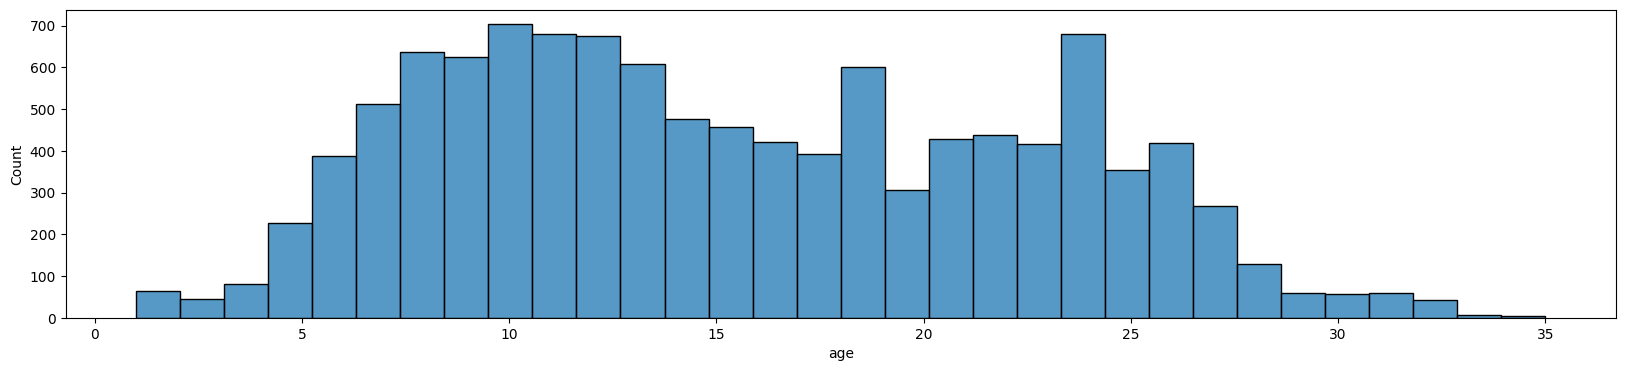

In [27]:
fig = plt.figure(figsize=(20,4))
histplot = sns.histplot(data=cleaned[cleaned['hasRegionalSupport']==True].sort_values('age'), x='age')

### Рассмотрим признак regionName. 

В столбце regionCode пропусков нет, посмотрим какое значения в строках с пропущенными значениями в regionName:

In [28]:
cleaned[cleaned['regionName'].isnull()].loc[:,['regionCode','regionName']].head()

,regionCode,regionName
31530,00,None
46886,00,None
51173,00,None
53323,00,None
53841,00,None


в строках с пропущенным именем региона проставлен 0 в признаке код региона. Т.к. нулевого региона не существует, можно сделать вывод, что это неявные пропуски.Вычленим номер региона из признака ОГРН (это 4 и 5 цифры в номере ОГРН)

In [29]:
#заменим нулевой код региона значениями региона из огрн
cleaned['regionCode'] = np.where((cleaned['regionCode']=='00'), cleaned['ogrn'].map(str).str[3:5], cleaned['regionCode'])

#Признак regionName можно удалить, т.к. он дублирует признак regionCode. 
cleaned = cleaned.drop(['regionName'], axis=1)

In [30]:
def regCod_group(arg): #функция для изменения кода региона на минимальный код этого же региона в тех случаях когда коды отличаются последними двумя разрядами
    if arg == 95: return 20
    elif arg == 80: return 75
    elif arg == 93: return 23
    elif arg == 84: return 24
    elif arg == 85: return 38
    elif arg == 88: return 24
    elif arg == 81: return 59
    elif arg == 91: return 39
    elif arg == 90: return 50
    elif arg == 96: return 66
    elif arg == 97: return 77
    elif arg == 98: return 78
    else: return arg

cleaned['regionCode']=cleaned['regionCode'].apply(regCod_group)

Проверим, есть ли зависимость вероятности получения поддержки от региона регистрации организации:

In [31]:
reg_hasSupport_mean = cleaned.groupby(by=['regionCode'])['hasRegionalSupport'].mean()*100
reg_count = cleaned.groupby(by=['regionCode'])['ogrn'].count()

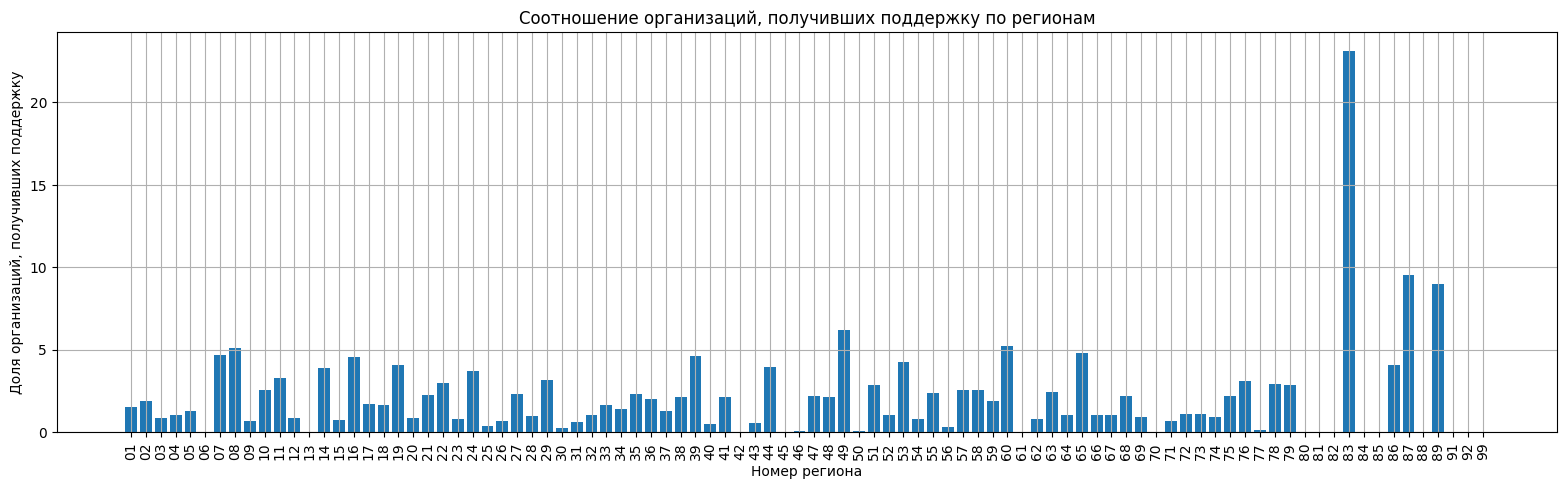

In [32]:
reg_hasSupport = cleaned.groupby(by=['regionCode'])['hasRegionalSupport'].mean()*100

fig = plt.figure(figsize=(15,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(
    x = reg_hasSupport.index,
    height = reg_hasSupport
)
axes.set_title('Соотношение организаций, получивших поддержку по регионам')
axes.set_xlabel("Номер региона")
axes.set_ylabel('Доля организаций, получивших поддержку')
axes.xaxis.set_tick_params(rotation=90)
axes.grid()

По графику видно, что есть регионы, где доля организаций, получивших поддержку выделяется на фоне остальных. Особенно выделяется 83 регион (Ненецкий АО). Выделим  пять регионов с максимальными значениями:

In [33]:
reg_hasSupport.sort_values(ascending=False).head()

regionCode
83    23.115578
87     9.523810
89     8.979001
49     6.176084
60     5.224826
Name: hasRegionalSupport, dtype: float64

По количеству полученной поддержки по регионам выглядит так:

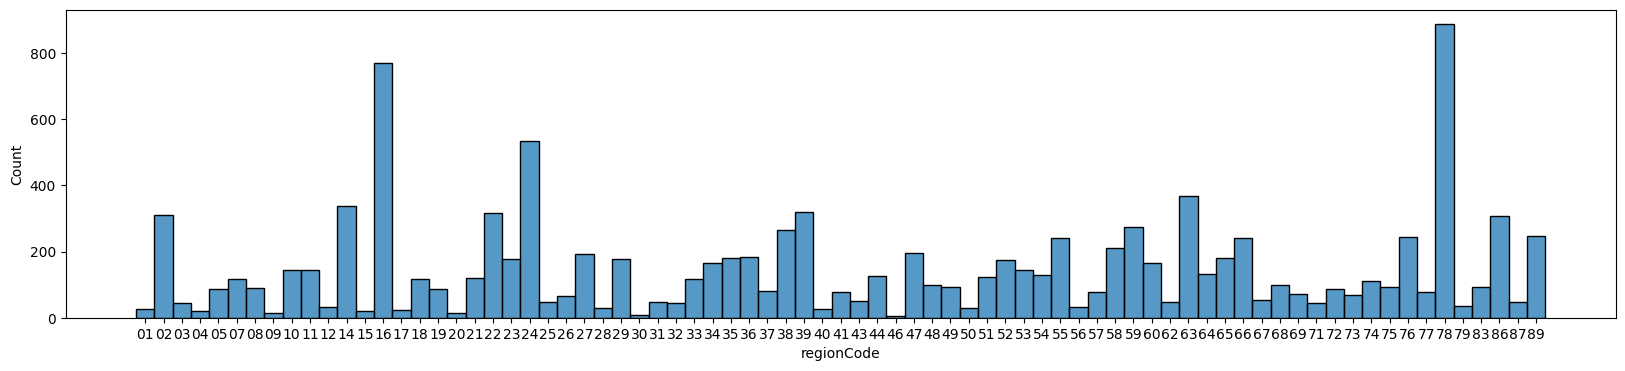

In [34]:
fig = plt.figure(figsize=(20,4))
histplot = sns.histplot(data=cleaned[cleaned['hasRegionalSupport']==True].sort_values('regionCode'), x='regionCode')

Из признака КПП можем взять информацию имел ли место "переезд" (смена юр.адреса) организации из одного региона в другой, а так же является организация иностранной.  Так  код города в шифровке номера ИНН, ОГРН дается по месту первой регистрации, а в КПП меняется при изменении юр.адреса. 

In [35]:
# определим наличие пропусков
cols_null_percent = cleaned.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

okpo              51.261506
oktmo_code        51.261506
okogu_code        51.261506
okato_code        51.261506
okfs_code         51.261506
mainOkved_name    27.729370
mainOkved_code    27.729370
shortName         20.118528
opf_code           6.174059
kpp                0.500149
inn                0.355746
opf_version        0.056695
dtype: float64

In [36]:
# удалим строки с пропусками в признаках kpp и inn, т.к. они номинальные и доля пропусков в них мала
cleaned = cleaned[~(cleaned['kpp'].isnull()|cleaned['inn'].isnull())]

In [37]:
cleaned['kpp'] = cleaned['kpp'].astype(str)


In [38]:
# Выделим цифры в коде КПП, которые указывают регион
cleaned['reg_kpp']=("0"+cleaned['kpp']).str[-9:-7].map(int)
cleaned['reg_kpp']=cleaned['reg_kpp'].apply(regCod_group) #приведем коды к минимальному значению, по регионам


In [39]:
#вводим признак наличия смены юр.адреса
cleaned['regionCode'] = cleaned['regionCode'].map(int)
cleaned['moving'] = np.where(cleaned['regionCode']==cleaned['reg_kpp'],0,1) 

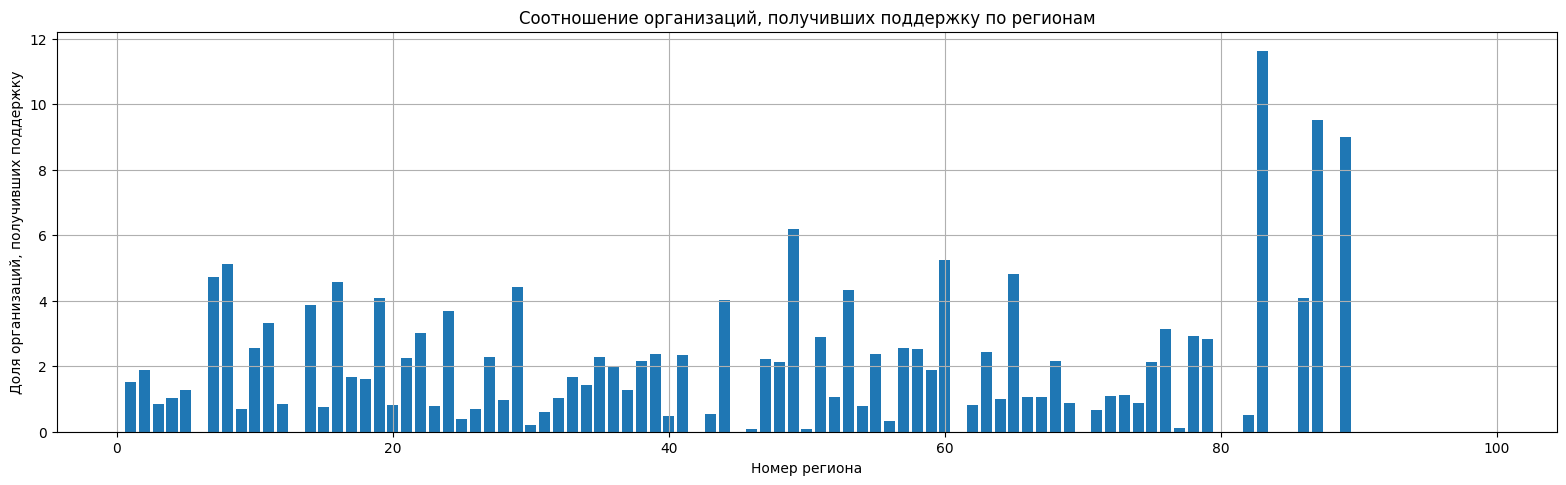

In [40]:
reg_hasSupport = cleaned.groupby(by=['reg_kpp'])['hasRegionalSupport'].mean()*100

fig = plt.figure(figsize=(15,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(
    x = reg_hasSupport.index,
    height = reg_hasSupport
)
axes.set_title('Соотношение организаций, получивших поддержку по регионам')
axes.set_xlabel("Номер региона")
axes.set_ylabel('Доля организаций, получивших поддержку')
axes.grid()

In [41]:
reg_hasSupport.sort_values(ascending=False).head()

reg_kpp
83    11.627907
87     9.523810
89     8.998549
49     6.192358
60     5.254777
Name: hasRegionalSupport, dtype: float64

Замечаем, что доля в 83 регионе увеличилась в два раза. Предположим, что такой рост вызван оттоком организаций из региона, не получавших поддержку. Поссмотрим общее количество НКО в регионах:

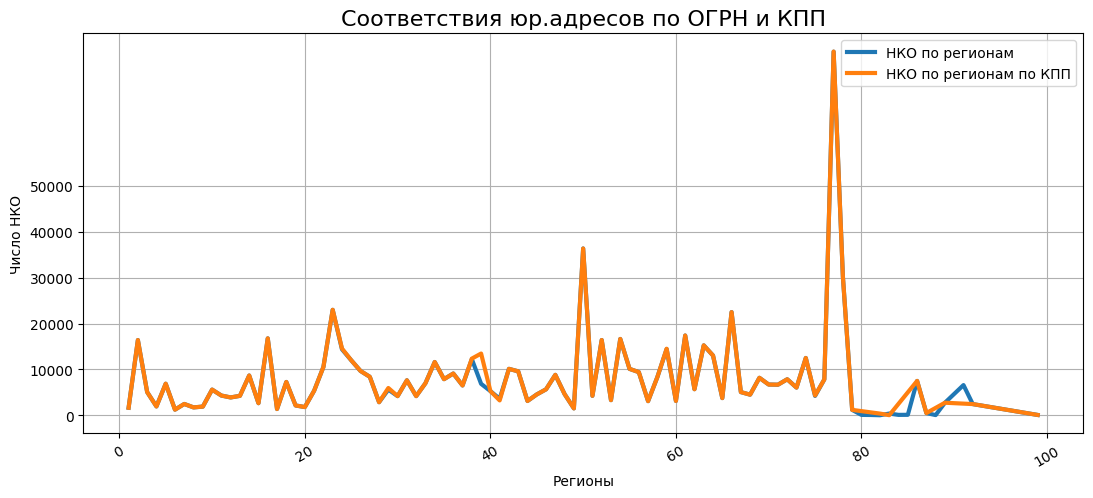

In [42]:
reg_NKO = cleaned.groupby(by=['regionCode'])['ogrn'].count()
kpp_reg_NKO=cleaned.groupby(by=['reg_kpp'])['ogrn'].count()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(reg_NKO, label='НКО по регионам', lw=3)
axes.plot(kpp_reg_NKO, label='НКО по регионам по КПП', lw=3)


#установка параметров отображения
axes.set_title('Соответствия юр.адресов по ОГРН и КПП', fontsize=16)
axes.set_xlabel('Регионы')
axes.set_ylabel('Число НКО')
axes.set_yticks(range(0, 60000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

Видим, что в 83 регионе действительно произошел отток организаций. В силу малочисленности показатель доли НКО, получавших поддержку сильно меняется.

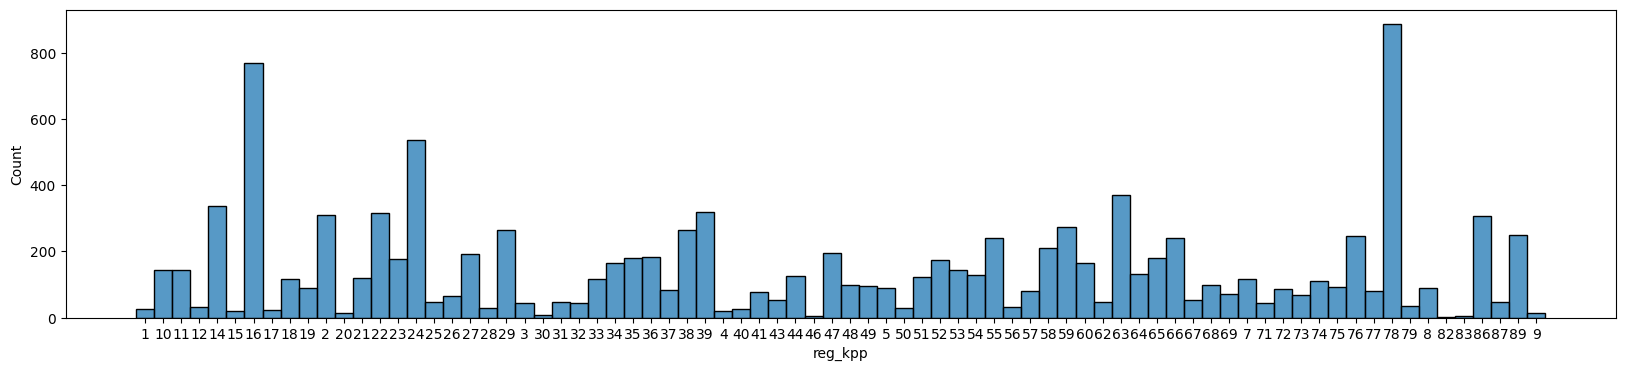

In [43]:
cleaned['reg_kpp'] = cleaned['reg_kpp'].astype(str)

fig = plt.figure(figsize=(20,4))
histplot = sns.histplot(data=cleaned[cleaned['hasRegionalSupport']==True].sort_values('reg_kpp'), x='reg_kpp')

Видим, что лидерами по количеству полученной поддержки являются 78 и 16 регионы

### Рассмотрим признак opf

opf_name различаются по написанию в зависимости от версии классификатора, плюс различаются применением числа в написании, приведем к однородному виду.
Заполним пропуски в признаке orf_code по названию opf_name

In [44]:
cleaned['opf_name']=cleaned['opf_name'].apply(lambda x: x.capitalize() if x is not None else None)

cleaned['opf_code']=cleaned['opf_code'].map(str)
cleaned['opf_code'] = cleaned['opf_code'].apply(lambda x: int(x) if x!='None' else None)

In [45]:
# для признака name, имеющего кодировку по КОПФ проведем корректировку названий согласно классификатора
kpof_df=pd.read_excel('data/kpof_code.xlsx')
kpof_df = kpof_df.rename(columns={'code':'opf_code'})#переименование столбца для объединения таблиц

cleaned = cleaned.merge(
    kpof_df,
    on='opf_code',
    how='left'
)

In [46]:
dict_df = cleaned[['opf_name','name_kopf']].dropna()#вспомогательный дата для составления словаря замен

#создадим словарь для приведения имен ОПФ к стандартным именам ОКОПФ
dict_opf = pd.Series(dict_df.name_kopf.values,index=dict_df.opf_name).to_dict()
#Заменим значения имен согласно словаря
cleaned=cleaned.replace({"opf_name": dict_opf})

In [47]:
# составим дополнительный словарь из имен, не попавших в основной словарь и произведем замену
dop_dict_opf ={'Общественный фонд':'Общественные фонды','Политическая партия':'Политические партии','Общественное учреждение':'Общественные учреждения',
        'Коллегия адвокатов':'Коллегии адвокатов','Союз':'Союзы','Некоммерческое учреждение':'Некоммерческие учреждения',
        'Религиозная организация':'Религиозные организации','Садоводческое некоммерческое товарищество':'Садоводческие или огороднические некоммерческие товарищества',
        'Профсоюзная организация':'Профсоюзные организации', 'Община':'Общины','Общественная организация':'Общественные  организации',
        'Казачье общество':'Казачьи общества, внесенные в государственный реестр казачьих обществ в Российской Федерации',
        'Общественные и религиозные организации (объединения)':'Религиозные организации',
        'Союз потребительских обществ':'Союзы потребительских обществ','Ассоциация':'Ассоциации (союзы)',
        'Садоводческие, огороднические или дачные некоммерческие товарищества':'Садоводческие или огороднические некоммерческие товарищества'                           
}
cleaned=cleaned.replace({"opf_name": dop_dict_opf})

In [48]:
#присвоим коды ОПФ согласно Общероссийского классификатора
okopf_code_df = pd.read_excel('data/okopf.xlsx')

okopf_code_df=okopf_code_df.rename(columns={'Название':'opf_name'})

cleaned = cleaned.merge(
    okopf_code_df,
    on='opf_name',
    how='left'
)

cleaned['opf_code'] = cleaned['Код'].combine_first(df['opf_code'])

cleaned = cleaned.drop(['opf_version','opf_name','name_kopf','Код'],axis=1)#удаляем признаки

### Рассмотрим признаки mainOkved_code и addOkved. 

mainOkved_name дублирует информацию из mainOkved_code, поэтому удалим его.

In [49]:
cleaned[cleaned['mainOkved_code'].isnull()]['hasRegionalSupport'].value_counts()

hasRegionalSupport
False    199834
True        313
Name: count, dtype: int64

т.к. важно не потерять данные, особенно для организаций с триггерным признаком и ограниченности ресурса для проведения запросов к ресурсу ДаДата, заполним признак ОКВЭД для тех организаций, у которых пропуски в признаке основной ОКВЭД, дополнительный ОКВЭД и истинный целевой признак  

In [50]:
# https://github.com/hflabs/dadata-py

from dadata import Dadata
token = ""
dadata = Dadata(token)

In [51]:
# функция запроса к API по ключу ОГРН, возвращает ОКВЭД
def okved_(ogrn):
    result = dadata.find_by_id("party", ogrn)
    okved = result[0]['data'].setdefault('okved')
    return okved
    
cleaned['ogrn']=cleaned['ogrn'].map(str).str[:-2] #ОГРН приводим к строчному виду


In [52]:
df_okved = cleaned[(cleaned['mainOkved_code'].isnull())&(cleaned['hasRegionalSupport']==True)].loc[:,['ogrn','mainOkved_code']]

df_okved['mainOkved_code']= df_okved['ogrn'].apply(okved_) #заполняем данные
df_okved =df_okved.drop('ogrn',axis=1).rename(columns={'mainOkved_code':'mainOkved'})

In [53]:
# объединяем полученный столбец с нашим дата
cleaned =cleaned.join(
    df_okved,
    how='left',
    )
cleaned['mainOkved_code']=cleaned['mainOkved_code'].combine_first(cleaned['mainOkved'])#заполняем пропуски в столбце mainOkved_code
cleaned = cleaned.drop('mainOkved',axis=1)

In [54]:
#функция преобразования списков словарей кодов с именами и версиями в список кодов
def list_addokved(arg):
    list_add_okved=[]
    for i in range(0,len(arg)):
        list_add_okved.append(arg[i]['code'][:2])
    return list_add_okved

cleaned['addOkved']=cleaned['addOkved'].apply(list_addokved)

In [1]:
# функция запроса к API по ключу ОГРН, возвращает список кодов
def codes_ (ogrn):
    list_codes = ['okpo','oktmo','okogu','okato']
    list_result = []
    result = dadata.find_by_id("party", ogrn)
    for i in list_codes:
        list_result.append(result[0]['data'].setdefault(i))
    return list_result

df_codes = cleaned[cleaned['okpo'].isnull()&cleaned['hasRegionalSupport']==True]

df_codes['codes']=df_codes['ogrn'].apply(lambda x: codes_(x)) #запоняем данные

df_codes[['okpo','oktmo','okogu','okato']] = pd.DataFrame(df_codes['codes'].to_list(),index=df_codes.index)
df_codes[['okpo','oktmo','okogu','okato']].info()

Все попытки заполнить пропуски в признаках okpo, oktmo_code, okogu_code, okato_code и okfs_code через запросы API дали пустые значения, поэтому удалим oktmo_code, okato_code. Так же удаляем признаки shortName и fullName, т.к. они дублируют признак ogrn. Признаки ОГОКУ и ОКПО для организаций с целевым признаком заполним строчными нулями, остальные пропуски удалим

In [56]:
cleaned = cleaned.drop(['mainOkved_name','shortName','fullName','oktmo_code','okato_code'],axis=1) 
cleaned = cleaned[~(cleaned['mainOkved_code'].isnull()|cleaned['opf_code'].isnull())]

cleaned = cleaned[(cleaned['okpo'].isnull()&cleaned['hasRegionalSupport']==True)|(cleaned['okpo'].notnull())]

In [57]:
#приводим признаки к строчному виду
cleaned[['okpo','okogu_code','okfs_code']] = cleaned[['okpo','okogu_code','okfs_code']].astype(str)

#заполняем пропуски строчными нулями
cleaned['okpo'] = cleaned['okpo'].apply(lambda x: '0' if x=='nan' else str(x)[:-8])
cleaned['okogu_code'] = cleaned['okogu_code'].apply(lambda x: '0' if x=='nan' else str(x)[:-4])
cleaned['okfs_code'] = cleaned['okfs_code'].apply(lambda x: '0' if x=='nan' else str(x)[:-2])

In [61]:
# определим наличие пропусков
cols_null_percent = cleaned.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

Удаляя наблюдения из-за пропусков в данных мы постарались максимально сохранить наблюдения с наличием целевого признака. Посмотрим как изменилось соотношение в целевом признаке

Text(0.5, 1.0, 'Соотношение организаций, получавших и не получавших поддержку')

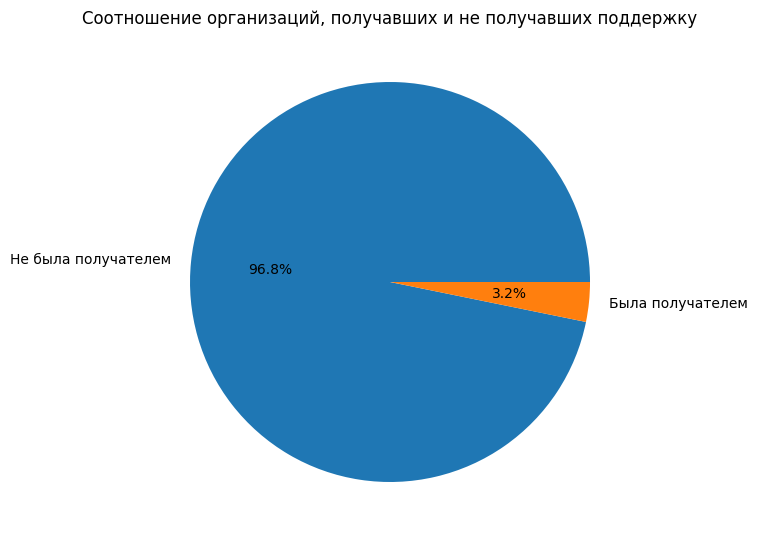

In [62]:
df_1 = cleaned.groupby(by='hasRegionalSupport')['hasRegionalSupport'].count()

fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(
    df_1,
    labels= ["Не была получателем","Была получателем"],
    autopct='%.1f%%',
    explode= [0,0]  
)
axes.set_title('Соотношение организаций, получавших и не получавших поддержку')

Процент класса 1 увеличился в два раза, но расбалансировка все же большая.

### Преобразуем некоторые признаки:

In [63]:
# Признак predecessors преобразуем в вид были (1) или не были (0) предшественники
cleaned['predecessors'] = cleaned['predecessors'].apply(lambda x: 0 if x==[] else 1)

# Признак successors преобразуем в вид есть (1) или нет (0) преемники
cleaned['successors'] = cleaned['successors'].apply(lambda x: 0 if x==[] else 1)

# Признак predecessors преобразуем в вид была (1) или не была (0) отчетность в Минюст
cleaned['reports'] = cleaned['reports'].apply(lambda x: 0 if x==[] else 1)

# в признаке administrators обозначим количество руководителей
cleaned['administrators'] = cleaned['administrators'].apply(lambda x: len(x))

Преобразуем признак incomeDetail

In [64]:
#извлечем из словарей значения totalCount и totalSum
cleaned['incomeDetail_grants_totalCount']= cleaned['incomeDetail_grants'].apply(lambda x: x.setdefault('totalCount'))
cleaned['incomeDetail_grants_totalSum']= cleaned['incomeDetail_grants'].apply(lambda x: x.setdefault('totalSum'))
cleaned['incomeDetail_fedSubsidies_totalCount']= cleaned['incomeDetail_fedSubsidies'].apply(lambda x: x.setdefault('totalCount'))
cleaned['incomeDetail_fedSubsidies_totalSum']= cleaned['incomeDetail_fedSubsidies'].apply(lambda x: x.setdefault('totalSum'))
cleaned['incomeDetail_contracts44_totalCount']= cleaned['incomeDetail_contracts44'].apply(lambda x: x.setdefault('totalCount'))
cleaned['incomeDetail_contracts44_totalSum']= cleaned['incomeDetail_contracts44'].apply(lambda x: x.setdefault('totalSum'))
cleaned['incomeDetail_contracts223_totalCount']= cleaned['incomeDetail_contracts223'].apply(lambda x: x.setdefault('totalCount'))
cleaned['incomeDetail_contracts223_totalSum']= cleaned['incomeDetail_contracts223'].apply(lambda x: x.setdefault('totalSum'))
cleaned['incomeDetail_contracts94_totalCount']= cleaned['incomeDetail_contracts94'].apply(lambda x: x.setdefault('totalCount'))
cleaned['incomeDetail_contracts94_totalSum']= cleaned['incomeDetail_contracts94'].apply(lambda x: x.setdefault('totalSum'))

#обобщим данные по контрактам
cleaned['incomeDetail_contracts_totalCount']= cleaned[['incomeDetail_contracts44_totalCount','incomeDetail_contracts223_totalCount','incomeDetail_contracts94_totalCount']].sum(1)
cleaned['incomeDetail_contracts_totalSum']= cleaned[['incomeDetail_contracts44_totalSum','incomeDetail_contracts223_totalSum','incomeDetail_contracts94_totalSum']].sum(1)

# Добавим признаки среднее по грантам, субсидиям и контрактам, а так же какую долю от общего дохода составляют доходы от грантов, субсидий и контрактов
cleaned['meanSum_grants'] = np.where(cleaned['incomeDetail_grants_totalCount']==0,0,cleaned.loc[:,'incomeDetail_grants_totalSum']/cleaned.loc[:,'incomeDetail_grants_totalCount'])
cleaned['meanSum_fedSubsidies'] = np.where(cleaned['incomeDetail_fedSubsidies_totalCount']==0,0,cleaned.loc[:,'incomeDetail_fedSubsidies_totalSum']/cleaned.loc[:,'incomeDetail_fedSubsidies_totalCount'])
cleaned['meanSum_contracts'] = np.where(cleaned['incomeDetail_contracts_totalCount']==0,0,cleaned.loc[:,'incomeDetail_contracts_totalSum']/cleaned.loc[:,'incomeDetail_contracts_totalCount'])

# добавим признаки для грантов, субсидий и контрактов от общей суммы всех доходов организации
cleaned['share_grants'] = np.where(cleaned['incomeTotal']==0,0,cleaned.loc[:,'incomeDetail_grants_totalSum']/cleaned.loc[:,'incomeTotal'])
cleaned['share_fedSubsidies'] = np.where(cleaned['incomeTotal']==0,0,cleaned.loc[:,'incomeDetail_fedSubsidies_totalSum']/cleaned.loc[:,'incomeTotal'])
cleaned['share_contracts'] = np.where(cleaned['incomeTotal']==0,0,cleaned.loc[:,'incomeDetail_contracts_totalSum']/cleaned.loc[:,'incomeTotal'])

# удалим признаки
cleaned = cleaned.drop(['incomeDetail_grants','incomeDetail_fedSubsidies','incomeDetail_contracts44','incomeDetail_contracts223',\
    'incomeDetail_contracts94','incomeDetail_grants_totalCount','incomeDetail_grants_totalSum','incomeDetail_fedSubsidies_totalCount',\
        'incomeDetail_fedSubsidies_totalSum','incomeDetail_contracts44_totalCount','incomeDetail_contracts44_totalSum',\
            'incomeDetail_contracts223_totalCount','incomeDetail_contracts223_totalSum','incomeDetail_contracts94_totalCount',\
                'incomeDetail_contracts94_totalSum','incomeDetail_contracts_totalCount','incomeDetail_contracts_totalSum'],axis=1)

### Приведем ДатаФрейм к итоговому виду. 

In [65]:
cleaned.reset_index(drop= True , inplace= True )#перенумерация индексов

In [66]:
#приведем признаки к строчному виду
cleaned[['regionCode','reg_kpp']]=cleaned[['regionCode','reg_kpp']].astype(str) 
cleaned['opf_code']=cleaned['opf_code'].astype(int).astype(str)

cleaned['mainOkved_code'] = cleaned['mainOkved_code'].apply(lambda x: x[:2])

# удалим признаки
cleaned = cleaned.drop(['originDate','dateOgrn','address','ogrn','inn','kpp','reg_kpp'],axis=1)

Выделили из ОКВЭД класс деятельности. Проверим, есть ли зависимость вероятности получения поддержки от класса экономической деятельности:

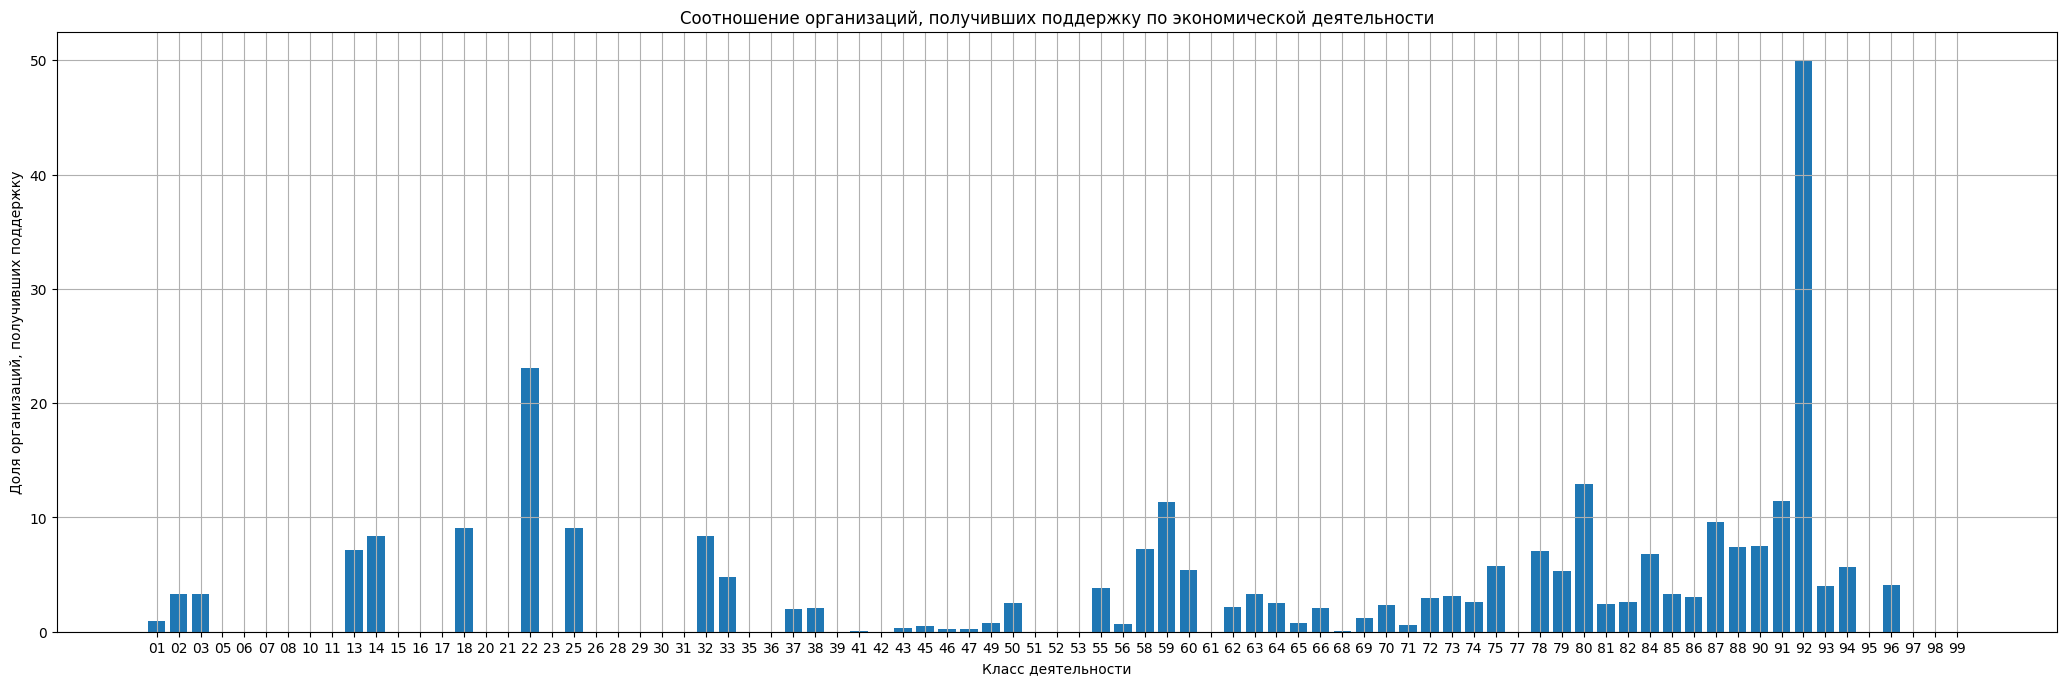

In [67]:
mainOkved_hasSupport = cleaned.groupby(by=['mainOkved_code'])['hasRegionalSupport'].mean()*100

fig = plt.figure(figsize=(20,6))
axes = fig.add_axes([0,0,1,1])
axes.bar(
    x = mainOkved_hasSupport.index,
    height = mainOkved_hasSupport
)
axes.set_title('Соотношение организаций, получивших поддержку по экономической деятельности')
axes.set_xlabel("Класс деятельности")
axes.set_ylabel('Доля организаций, получивших поддержку')
axes.grid()

In [68]:
mainOkved_hasSupport.sort_values(ascending=False).head()

mainOkved_code
92    50.000000
22    23.076923
80    12.946429
91    11.449814
59    11.320755
Name: hasRegionalSupport, dtype: float64

In [69]:
display(cleaned[cleaned['mainOkved_code'] =='59']['mainOkved_version'].values[0])
display(cleaned[cleaned['mainOkved_code'] =='87']['mainOkved_version'].values[0])

'ОК 029-2014 (КДЕС Ред. 2)'

'ОК 029-2014 (КДЕС Ред. 2)'

Видим, что наибольшая доля организаций, получивших поддержку среди тех, кто в качестве основного вида деятельности обозначил коды:
- 59 ( версии 2014 года) - Производство кинофильмов, видеофильмов и телевизионных программ, издание звукозаписей и нот
- 87 ( версии 2014 года) - Деятельность по уходу с обеспечением проживания

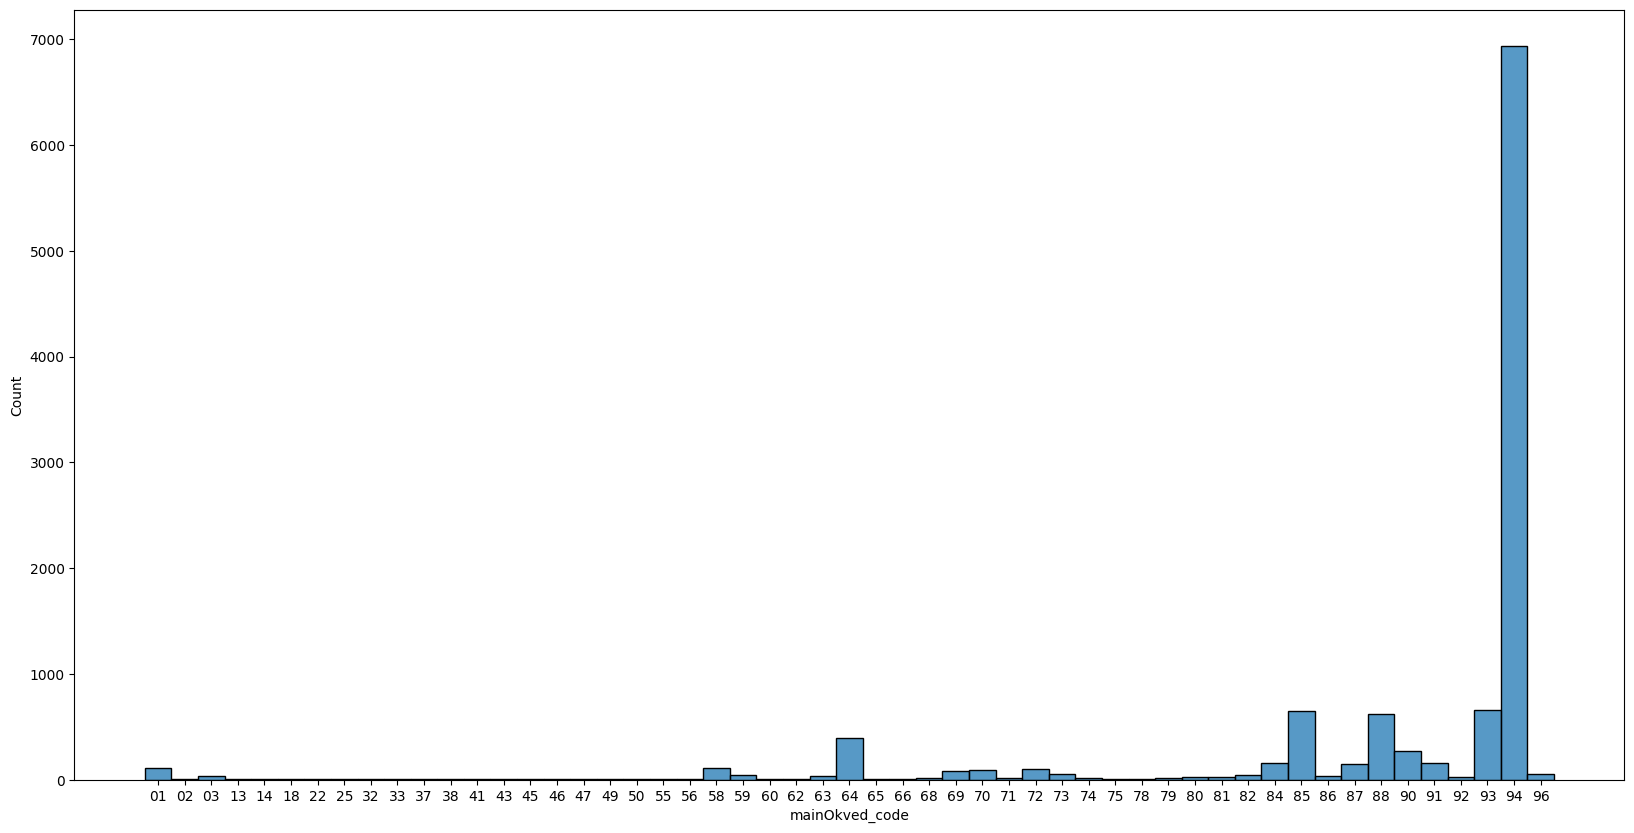

In [70]:
fig = plt.figure(figsize=(20,10))
histplot = sns.histplot(data=cleaned[cleaned['hasRegionalSupport']==True].sort_values('mainOkved_code'), x='mainOkved_code')

Но количественно абсолютное большинство за организациями с классом деятельности по ОКВЭД 94 - Деятельность общественных организаций

### Кодируем признаки

In [71]:
cleaned['egrulStatus']=np.where(cleaned['egrulStatus']=='Действует',1,0)

cleaned['mainOkved_version'] = np.where(cleaned['mainOkved_version']=='ОК 029-2014 (КДЕС Ред. 2)',1,0)

cleaned['hasRegionalSupport'] = np.where(cleaned['hasRegionalSupport'],1,0)


In [72]:
columns_for_change = ['minjustStatus', 'egrulStatus', 'regionCode', 'incomeTotal',
       'administrators', 'okpo', 'successors',
       'predecessors', 'reports', 'statusDetail_shortName',
       'opf_code', 'mainOkved_code', 'mainOkved_version', 'okogu_code',
       'okfs_code', 'age', 'moving', 'meanSum_grants', 'meanSum_fedSubsidies',
       'meanSum_contracts', 'share_grants', 'share_fedSubsidies',
       'share_contracts']

In [73]:
for column in columns_for_change:
    print('Число уникальных значений признака {}: '.format(column), cleaned[column].nunique())

Число уникальных значений признака minjustStatus:  3
Число уникальных значений признака egrulStatus:  2
Число уникальных значений признака regionCode:  89
Число уникальных значений признака incomeTotal:  25182
Число уникальных значений признака administrators:  14
Число уникальных значений признака okpo:  101
Число уникальных значений признака successors:  2
Число уникальных значений признака predecessors:  2
Число уникальных значений признака reports:  2
Число уникальных значений признака statusDetail_shortName:  5
Число уникальных значений признака opf_code:  129
Число уникальных значений признака mainOkved_code:  83
Число уникальных значений признака mainOkved_version:  2
Число уникальных значений признака okogu_code:  30
Число уникальных значений признака okfs_code:  28
Число уникальных значений признака age:  36
Число уникальных значений признака moving:  2
Число уникальных значений признака meanSum_grants:  9362
Число уникальных значений признака meanSum_fedSubsidies:  2166
Число

In [74]:
#применим метод однократного кодирования для признаков:
dum_columns = ['minjustStatus', 'statusDetail_shortName']
cleaned = pd.get_dummies(cleaned,columns=dum_columns) 

In [75]:
#применим двоичное кодирование для признаков с числом уникальных значений >15
bin_columns = ['regionCode','opf_code','mainOkved_code','okpo','okogu_code','okfs_code']

for col in bin_columns:
    bin_encoder = ce.BinaryEncoder(cols=col)
    bin = bin_encoder.fit_transform(cleaned[col])
    cleaned = pd.concat([cleaned,bin],axis=1)


In [76]:
#для признака addOkved применим MultiLabelBinarizer, т.к. признак содержит списки
mlb = MultiLabelBinarizer(sparse_output=True)

cleaned = cleaned.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(cleaned.pop('addOkved')),
                index=cleaned.index,
                columns=mlb.classes_))

Для числовых данных проведем Преобразование Йео-Джонсона

In [77]:
#Статистика до преобразования
cleaned[['incomeTotal', 'meanSum_grants','meanSum_fedSubsidies','meanSum_contracts','age']].describe()

,incomeTotal,meanSum_grants,meanSum_fedSubsidies,meanSum_contracts,age
count,3.428040e+05,3.428040e+05,3.428040e+05,3.428040e+05,342804.000000
mean,1.098032e+07,5.805582e+04,1.403848e+06,2.042246e+05,14.552272
std,2.290788e+09,5.952066e+05,3.307500e+08,3.330922e+07,8.602534
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,13.000000
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,22.000000
max,1.227756e+12,1.149894e+08,1.747034e+11,1.644578e+10,35.000000


In [78]:
box_cox = PowerTransformer(method = 'yeo-johnson')
 
data_box_cox = box_cox.fit_transform(cleaned[['incomeTotal', 'meanSum_grants','meanSum_fedSubsidies','meanSum_contracts','age']].values)
data_box_cox = pd.DataFrame(data_box_cox, columns = ['transformed_incomeTotal', 'transformed_meanSum_grants','transformed_meanSum_fedSubsidies',\
    'transformed_meanSum_contracts','transformed_age'])

In [79]:
#Статистика после преобразования
data_box_cox.describe()

,transformed_incomeTotal,transformed_meanSum_grants,transformed_meanSum_fedSubsidies,transformed_meanSum_contracts,transformed_age
count,3.428040e+05,3.428040e+05,3.428040e+05,3.428040e+05,3.428040e+05
mean,-1.906919e-17,2.524594e-17,-2.396085e-17,-4.709260e-17,5.571519e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.085723e-01,-1.804720e-01,-8.949793e-02,-2.466106e-01,-2.514732e+00
25%,-3.085723e-01,-1.804720e-01,-8.949793e-02,-2.466106e-01,-8.229295e-01
50%,-3.085723e-01,-1.804720e-01,-8.949793e-02,-2.466106e-01,-1.644513e-02
75%,-3.085723e-01,-1.804720e-01,-8.949793e-02,-2.466106e-01,8.950808e-01
max,3.240940e+00,5.541024e+00,1.117344e+01,4.054989e+00,1.916827e+00


In [80]:
cleaned = pd.concat([cleaned,data_box_cox],axis=1)
cleaned = cleaned.drop(['incomeTotal', 'meanSum_grants','meanSum_fedSubsidies','meanSum_contracts','age'],axis=1)

In [81]:
data = cleaned.copy()


In [82]:
data.to_csv('data/data_final.csv',index=False)